In [ ]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers



/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


In [ ]:
# function to plot reward
import matplotlib.pyplot as plt

def plot_reward(reward_list, reward_avg_list):
  plt.plot(reward_list, 'g', label='Reward')
  plt.plot(reward_avg_list, 'r', label='Average Reward')
  plt.xlabel('Episode')
  plt.ylabel('Reward Value')
  plt.title('Rewards Per Episode')
  plt.grid()
  plt.legend()
  plt.show()

# function to plot epsilon
def plot_epsilon(epsilon_list):
  plt.plot(epsilon_list)
  plt.xlabel('Episode')
  plt.ylabel('Epsilon Values')
  plt.title('Epsilon Decay')
  plt.grid()
  plt.show()

# save rewards
def save(file_name, save_list):
  with open(file_name, 'wb') as file:
    pickle.dump(save_list, file)

In [ ]:
import tensorflow as tf
import numpy as np

class ActorCritic(tf.Module):
    def __init__(self, num_inputs, num_actions, num_hidden):
        super().__init__()
        self.common = tf.Variable(tf.random.normal([num_inputs, num_hidden]))
        self.common_bias = tf.Variable(tf.zeros([num_hidden]))
        
        self.action = tf.Variable(tf.random.normal([num_hidden, num_actions]))
        self.action_bias = tf.Variable(tf.zeros([num_actions]))
        
        self.critic = tf.Variable(tf.random.normal([num_hidden, 1]))
        self.critic_bias = tf.Variable(tf.zeros([1]))

    def __call__(self, inputs):
        common = tf.nn.relu(tf.matmul(inputs, self.common) + self.common_bias)
        action = tf.nn.softmax(tf.matmul(common, self.action) + self.action_bias)
        critic = tf.matmul(common, self.critic) + self.critic_bias
        return action, critic

num_inputs = 4
num_actions = 2
num_hidden = 128

model = ActorCritic(num_inputs, num_actions, num_hidden)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
huber_loss = tf.keras.losses.Huber()



In [ ]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model

def wind_noise(action):
    wind = np.random.rand()
    double_action = False
    if wind < 0.1:
        wind_action = 1 - action
        double_action = True
    else:
        wind_action = action
    return double_action, wind_action

def modified_env_step(environment, action):
    double_action, wind_action = wind_noise(action)

    if not double_action:
        observation, reward, terminated, info = environment.step(wind_action)
    else:
        observation, reward1, terminated, info = environment.step(action)
        if terminated:
            reward = reward1
        else:
            observation, reward2, terminated, info = environment.step(wind_action)
            reward = reward1 + reward2

    return observation, reward, terminated, info
def calculate_losses(history):
    actor_losses = []
    critic_losses = []
    for log_prob, value, ret in history:
        diff = ret - value
        actor_losses.append(-log_prob * diff)
        critic_losses.append(huber_loss(tf.expand_dims(value, 0), tf.expand_dims(ret, 0)))

    return sum(actor_losses) + sum(critic_losses)

def run_episode(env, model, optimizer, max_steps_per_episode):
    state = env.reset()
    episode_reward = 0
    with tf.GradientTape() as tape:
        for timestep in range(1, max_steps_per_episode):
            state = tf.convert_to_tensor(state)
            state = tf.expand_dims(state, 0)
            action_probs, critic_value = model(state)
            critic_value_history.append(critic_value[0, 0])

            action = np.random.choice(num_actions, p=np.squeeze(action_probs))
            action_probs_history.append(tf.math.log(action_probs[0, action]))

            state, reward, done, _ = modified_env_step(env, action)
            rewards_history.append(reward)
            episode_reward += reward

            if done:
                break

        returns = calculate_returns(rewards_history)
        history = zip(action_probs_history, critic_value_history, returns)
        loss_value = calculate_losses(history)
        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        action_probs_history.clear()
        critic_value_history.clear()
        rewards_history.clear()

    return episode_reward

def calculate_returns(rewards_history):
    returns = []
    discounted_sum = 0
    for r in rewards_history[::-1]:
        discounted_sum = r + gamma * discounted_sum
        returns.insert(0, discounted_sum)

    returns = np.array(returns)
    returns = (returns - np.mean(returns)) / (np.std(returns) + eps)
    return returns.tolist()

gamma = 0.99
eps = 0.99
max_steps_per_episode = 100
num_episodes = 500
env = gym.make("CartPole-v1")

In [ ]:
running_reward = 0
r_van = []
avg_rvan = []
max_steps_per_episode=100
critic_value_history=[]
action_probs_history=[]
rewards_history=[]
for episode_count in range(1, num_episodes + 1):
    episode_reward = run_episode(env, model, optimizer, max_steps_per_episode)
    running_reward = 0.05 * episode_reward + (1 - 0.05) * running_reward
    r_van.append(running_reward)
    avg_rvan.append(sum(r_van) / len(r_van))

    if episode_count % 10 == 0:
        template = "running reward: {:.2f} at episode {}"
        print(template.format(running_reward, episode_count))



/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


running reward: 12.15 at episode 10
running reward: 22.09 at episode 20
running reward: 36.73 at episode 30
running reward: 56.11 at episode 40
running reward: 126.24 at episode 50
running reward: 197.08 at episode 60
running reward: 187.40 at episode 70
running reward: 153.42 at episode 80
running reward: 125.08 at episode 90
running reward: 130.44 at episode 100
running reward: 135.87 at episode 110
running reward: 153.53 at episode 120
running reward: 183.20 at episode 130
running reward: 235.59 at episode 140
running reward: 241.18 at episode 150
running reward: 237.48 at episode 160
running reward: 240.20 at episode 170
running reward: 186.44 at episode 180
running reward: 152.16 at episode 190
running reward: 115.32 at episode 200
running reward: 116.77 at episode 210
running reward: 118.92 at episode 220
running reward: 114.49 at episode 230
running reward: 121.63 at episode 240
running reward: 129.73 at episode 250
running reward: 232.41 at episode 260
running reward: 288.42 at

In [ ]:
def select_greedy_action(state, model):
    state = tf.convert_to_tensor(state)
    state = tf.expand_dims(state, 0)
    action_probs, _ = model(state)
    greedy_action = np.argmax(action_probs)
    return greedy_action


def test_model(env, model, num_test_episodes, max_steps_per_episode):
    episode_rewards = []

    for episode in range(num_test_episodes):
        state = env.reset()
        episode_reward = 0

        for timestep in range(1, max_steps_per_episode):
            greedy_action = select_greedy_action(state, model)
            state, reward, done, _ = env.step(greedy_action)
            episode_reward += reward

            if done:
                break

        episode_rewards.append(episode_reward)

    return episode_rewards


num_test_episodes = 100
episode_rewards = test_model(env, model, num_test_episodes, max_steps_per_episode)
average_reward = np.mean(episode_rewards)
print("Average reward over 100 episodes: {:.2f}".format(average_reward))


Average reward over 100 episodes: 500.00


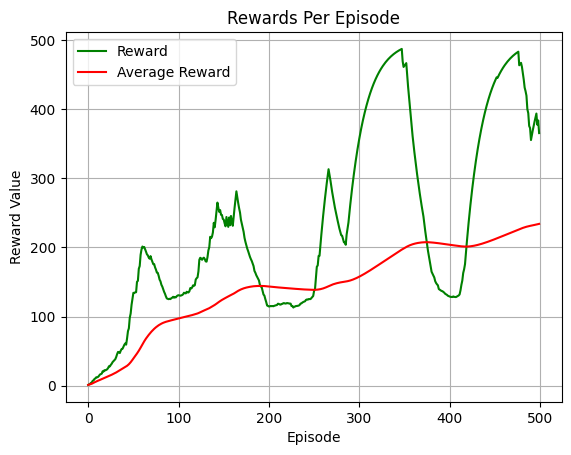

[1.05, 1.44875, 1.7675416666666666, 2.2968734375, 2.7856238125, 3.4969521848958336, 4.097518207700893, 4.806062010151367, 5.44734125301671, 6.117476771329287, 6.65600266614802, 7.167102321770567, 7.715766651398805, 8.313551296055374, 8.87801548250243, 9.410107539103727, 10.08139027025745, 10.659136270258767, 11.274801590601312, 11.815508435517684, 12.342602870230285, 12.856133057322465, 13.404051343393022, 14.015771743880729, 14.570383830419225, 15.167177537402178, 15.778862413845696, 16.43135074696936, 17.085307926530515, 17.74000777919719, 18.40291037764903, 19.12392845693012, 19.9247704572932, 20.77328099518064, 21.563627889838134, 22.276128537142164, 23.04171881000708, 23.82937937294076, 24.585656291363115, 25.373714139875084, 26.197588715006177, 27.028478105940252, 27.77991340527944, 28.700215059219662, 29.813755321675156, 30.968218260904628, 32.400236978756006, 33.90042877294699, 35.597133715232296, 37.40993148888127, 39.31023030827177, 41.13232035453398, 42.90352123611281, 44.61

In [ ]:
plot_reward(r_mod,avg_rmod)

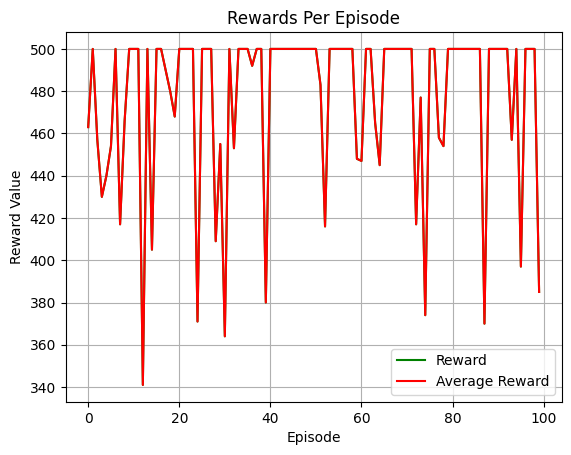

In [ ]:
plot_reward(episode_rewards,episode_rewards)

In [ ]:
import pickle
with open("a2c_noise_cartpole_train.pkl", "wb") as f:
    pickle.dump(r_mod, f)

with open("a2c_noise_cartpole_test.pkl", "wb") as f:
    pickle.dump(episode_rewardss, f)
